In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import sklearn.metrics

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/property-sales/raw_sales.csv
/kaggle/input/property-sales/ma_lga_12345.csv


# Комп’ютерний практикум No1. Навчання рекурентних нейронних мереж LSTM i GRU засобами TensorFlow для прогнозування часового ряду
Мета роботи:
- Виконати довгострокове прогнозування часового ряду на основi глибоких ре- курентних нейронних мереж (RNN) LSTM i GRU.
- Дослiдити, чи пiдвищиться якiсть прогнозування шляхом включення шарiв з дропаутами мiж рекурентними шарами глибокої моделi RNN.
- Виконати довгострокове прогнозування часового ряду на основi глибокої моделi зi згортковими шарами conv1D та шарами пулiнгу max_pool1D.

## Хiд виконання роботи:
### Пiдготувати початковi часовi ряди. Розбити їх на навчальний i тестовий набори у спiввiдношеннi 1:3, вiдповiдно.

In [2]:
# https://www.kaggle.com/code/amirrezaeian/time-series-data-analysis-using-lstm-tutorial
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
data = pd.read_csv("/kaggle/input/property-sales/raw_sales.csv")

In [3]:
data['datesold'] = pd.to_datetime(data['datesold'], format='%Y-%m-%d %H:%M:%S')
data.set_index('datesold', inplace=True)
data = data.sort_index(ascending=True)

In [4]:
data.sample(5)

,postcode,price,propertyType,bedrooms
datesold,,,,
2009-04-02,2903,423000,house,4
2018-07-07,2906,672000,house,4
2017-05-04,2617,521000,house,3
2016-08-26,2615,505000,house,4
2013-03-02,2607,570000,house,3


In [5]:
data.describe()

,postcode,price,bedrooms
count,29580.000000,2.958000e+04,29580.000000
mean,2730.249730,6.097363e+05,3.250169
std,146.717292,2.817079e+05,0.951275
min,2600.000000,5.650000e+04,0.000000
25%,2607.000000,4.400000e+05,3.000000
50%,2615.000000,5.500000e+05,3.000000
75%,2905.000000,7.050000e+05,4.000000
max,2914.000000,8.000000e+06,5.000000


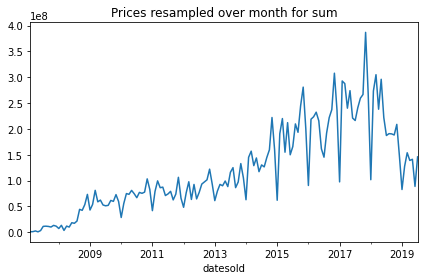

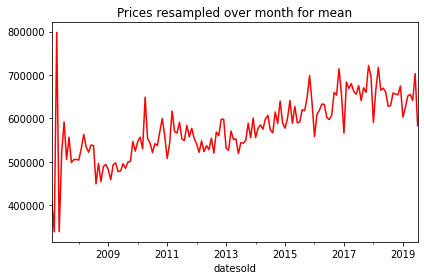

In [6]:
data.price.resample('M').sum().plot(title='Prices resampled over month for sum')
plt.tight_layout()
plt.show()   

data.price.resample('M').mean().plot(title='Prices resampled over month for mean', color='red')
plt.tight_layout()
plt.show()   

In [7]:
data = data[['price']]
data = data.resample('M').mean()

In [8]:
data.sample(5)

,price
datesold,
2018-02-28,666738.265854
2013-02-28,527025.748344
2009-06-30,479053.181818
2019-06-30,703275.396825
2013-12-31,601101.142857


In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
values = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 5, 1)
reframed.head()

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
5,0.148619,0.000000,1.000000,0.000363,0.394622,0.551044
6,0.000000,1.000000,0.000363,0.394622,0.551044,0.362519
7,1.000000,0.000363,0.394622,0.551044,0.362519,0.474291
8,0.000363,0.394622,0.551044,0.362519,0.474291,0.347238
9,0.394622,0.551044,0.362519,0.474291,0.347238,0.362156


In [11]:
reframed[reframed.isna().any(axis=1)]

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)


In [12]:
reframed.shape, values.shape

((145, 6), (150, 1))

In [13]:
values = reframed.values

n_train_time = int(reframed.shape[0]*(2/3))
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(96, 1, 5) (96,) (49, 1, 5) (49,)


### Побудувати першу модель, використовуючи один шар базових рекурентних нейронiв, та аналогiчнi моделi iз одним шаром комiрок LSTM i GRU. Навчити цi три моделi на навчальних даних. Використати функцiю втрат Mean Squared Error (MSE). Побудувати графiки значень функцiї втрат залежно вiд кiлькостi епох на навчальнiй i тестовiй множинах.

In [14]:
def show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def build_model1(keras_layer, units_n):
    model = tf.keras.Sequential()
    model.add(keras_layer(units_n, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mae')
    return model

def get_simple_models():
    # RNN
    rnn = build_model1(tf.keras.layers.SimpleRNN, 100)
    # LSTM
    lstm = build_model1(tf.keras.layers.LSTM, 100)
    # GRU
    gru = build_model1(tf.keras.layers.GRU, 100)
    return rnn, lstm, gru

fit_model = lambda model, epochs: model.fit(x=train_X, y=train_y, epochs=epochs, validation_data=(test_X, test_y))

rnn, lstm, gru = get_simple_models()

2022-04-23 18:58:13.597595: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2022-04-23 18:58:13.741533: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
3/3 [==============================] - 2s 232ms/step - loss: 0.5450 - mae: 0.7263 - val_loss: 1.0119 - val_mae: 1.0019
Epoch 2/20
3/3 [==============================] - 0s 24ms/step - loss: 0.4269 - mae: 0.6425 - val_loss: 0.8004 - val_mae: 0.8904
Epoch 3/20
3/3 [==============================] - 0s 14ms/step - loss: 0.3270 - mae: 0.5602 - val_loss: 0.6141 - val_mae: 0.7790
Epoch 4/20
3/3 [==============================] - 0s 25ms/step - loss: 0.2394 - mae: 0.4778 - val_loss: 0.4545 - val_mae: 0.6689
Epoch 5/20
3/3 [==============================] - 0s 21ms/step - loss: 0.1669 - mae: 0.3966 - val_loss: 0.3220 - val_mae: 0.5613
Epoch 6/20
3/3 [==============================] - 0s 22ms/step - loss: 0.1102 - mae: 0.3184 - val_loss: 0.2162 - val_mae: 0.4576
Epoch 7/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0656 - mae: 0.2428 - val_loss: 0.1362 - val_mae: 0.3598
Epoch 8/20
3/3 [==============================] - 0s 25ms/step - loss: 0.0365 - mae: 0.1731 - va

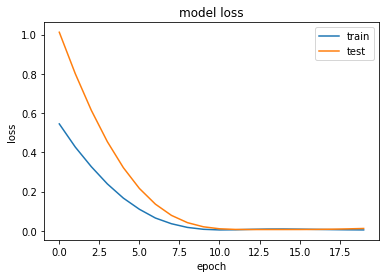

In [15]:
history = fit_model(rnn, 20)
show_loss(history)

Epoch 1/20
3/3 [==============================] - 2s 141ms/step - loss: 0.2081 - mae: 0.4471 - val_loss: 0.4197 - val_mae: 0.6426
Epoch 2/20
3/3 [==============================] - 0s 25ms/step - loss: 0.1927 - mae: 0.4298 - val_loss: 0.3915 - val_mae: 0.6204
Epoch 3/20
3/3 [==============================] - 0s 14ms/step - loss: 0.1784 - mae: 0.4129 - val_loss: 0.3640 - val_mae: 0.5978
Epoch 4/20
3/3 [==============================] - 0s 13ms/step - loss: 0.1642 - mae: 0.3956 - val_loss: 0.3369 - val_mae: 0.5747
Epoch 5/20
3/3 [==============================] - 0s 13ms/step - loss: 0.1504 - mae: 0.3780 - val_loss: 0.3100 - val_mae: 0.5509
Epoch 6/20
3/3 [==============================] - 0s 25ms/step - loss: 0.1368 - mae: 0.3598 - val_loss: 0.2831 - val_mae: 0.5259
Epoch 7/20
3/3 [==============================] - 0s 15ms/step - loss: 0.1231 - mae: 0.3408 - val_loss: 0.2563 - val_mae: 0.4997
Epoch 8/20
3/3 [==============================] - 0s 14ms/step - loss: 0.1096 - mae: 0.3208 - va

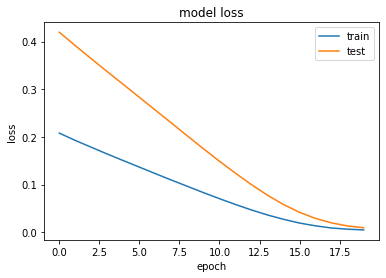

In [16]:
history = fit_model(lstm, 20)
show_loss(history)

Epoch 1/20
3/3 [==============================] - 1s 228ms/step - loss: 0.3252 - mae: 0.5601 - val_loss: 0.6185 - val_mae: 0.7820
Epoch 2/20
3/3 [==============================] - 0s 24ms/step - loss: 0.2666 - mae: 0.5064 - val_loss: 0.5150 - val_mae: 0.7128
Epoch 3/20
3/3 [==============================] - 0s 14ms/step - loss: 0.2157 - mae: 0.4545 - val_loss: 0.4239 - val_mae: 0.6459
Epoch 4/20
3/3 [==============================] - 0s 13ms/step - loss: 0.1726 - mae: 0.4051 - val_loss: 0.3446 - val_mae: 0.5813
Epoch 5/20
3/3 [==============================] - 0s 25ms/step - loss: 0.1360 - mae: 0.3579 - val_loss: 0.2763 - val_mae: 0.5194
Epoch 6/20
3/3 [==============================] - 0s 22ms/step - loss: 0.1050 - mae: 0.3129 - val_loss: 0.2183 - val_mae: 0.4602
Epoch 7/20
3/3 [==============================] - 0s 21ms/step - loss: 0.0797 - mae: 0.2700 - val_loss: 0.1694 - val_mae: 0.4036
Epoch 8/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0586 - mae: 0.2283 - va

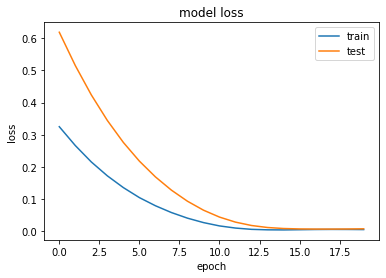

In [17]:
history = fit_model(gru, 20)
show_loss(history)

### Побудувати прогнози на тестовому наборi даних. Оцiнити якiсть прогнозiв на тестовому наборi, використовуючи RMSE, MAE та MAPE.

In [18]:
def eval_model(model, x, y, verbose=True):
    preds = model.predict(x)
    rmse = sklearn.metrics.mean_squared_error(y, preds)
    mae = sklearn.metrics.mean_absolute_error(y, preds)
    mape = sklearn.metrics.mean_absolute_percentage_error(y, preds)
    
    if verbose:
        print_err = lambda name, err: print(f'{name}: {err}')
        print_err('rmse', rmse), print_err('mae', mae), print_err('mape', mape)
    return rmse, mae, mape

In [19]:
print('GRU')
eval_model(gru, test_X, test_y)

GRU
rmse: 0.008084936093727152
mae: 0.07289999569448814
mape: 0.10859972596029237


(0.008084936093727152, 0.07289999569448814, 0.10859972596029237)

In [20]:
print('LSTM')
eval_model(lstm, test_X, test_y)

LSTM
rmse: 0.009637464291618934
mae: 0.08075080144246909
mape: 0.11855864779076838


(0.009637464291618934, 0.08075080144246909, 0.11855864779076838)

In [21]:
print('RNN')
eval_model(rnn, test_X, test_y)

RNN
rmse: 0.012349954454569722
mae: 0.09445903430890173
mape: 0.13665906829250066


(0.012349954454569722, 0.09445903430890173, 0.13665906829250066)

### Вiдобразити графiки реальних даних та прогнозiв на однiй координатнiй вiсi (окремо по кожнiй моделi).

In [22]:
def plot_data(model, x, y, model_name):
    preds = model.predict(x)
    plt.figure(figsize=(10,6))
    plt.plot(y)
    plt.plot(preds)
    plt.title(model_name)
    plt.legend(['true data', 'predicted data'], loc='upper left')
    plt.show()

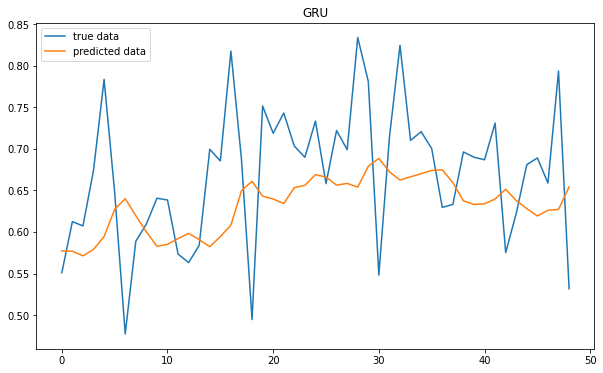

In [23]:
plot_data(gru, test_X, test_y, 'GRU')

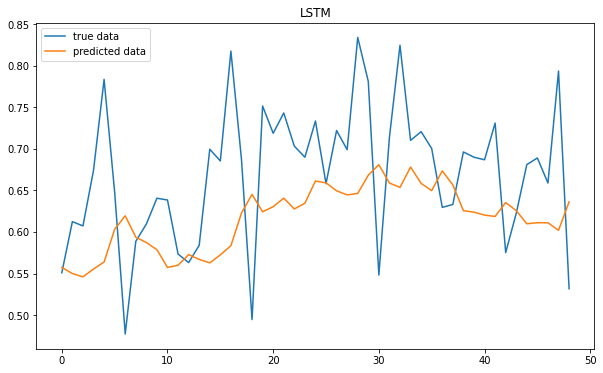

In [24]:
plot_data(lstm, test_X, test_y, 'LSTM')

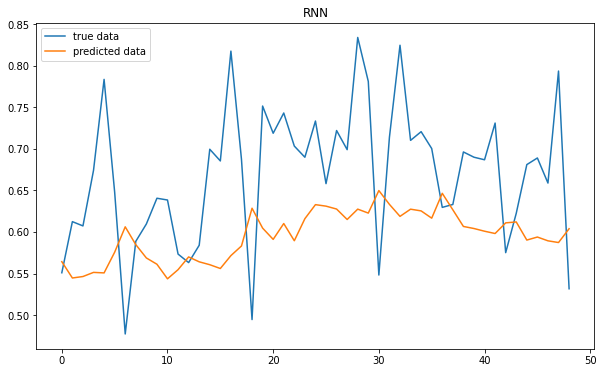

In [25]:
plot_data(rnn, test_X, test_y, 'RNN')

### Спробувати пiдiбрати кiлькiсть нейронiв у рекурентному шарi, кiлькiсть часових крокiв, а також кiлькiсть епох i розмiр батчу, щоб покращити якiсть прогнозiв.

In [26]:
def get_data(time_steps_n):
    values = data.values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, time_steps_n, 1)
    values = reframed.values

    n_train_time = int(reframed.shape[0]*(2/3))
    train = values[:n_train_time, :]
    test = values[n_train_time:, :]

    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y


def fit_multiple_choices(keras_layer, time_steps, batch_sizes, units_n, epochs_n):
    params_variants = [[i,j,k,m] for i in time_steps for j in batch_sizes for k in units_n for m in epochs_n]
    print(f'len params variants: {len(params_variants)}')
    for idx, params in enumerate(params_variants):
        print(f'|{idx}. {params}|', end=' ')
        train_X_n, train_y_n, test_X_n, test_y_n = get_data(params[0])
        model_n = build_model1(keras_layer, params[3])
        model_n.fit(x=train_X_n, y=train_y_n, epochs=params[3], validation_data=(test_X_n, test_y_n), batch_size=params[1], verbose=0)
        rmse, mae, mape = eval_model(model_n, test_X_n, test_y_n, verbose=False)
        params_variants[idx] = params_variants[idx] + [rmse, mae, mape]
    params_variants = pd.DataFrame(params_variants,
                                   columns=['time_step', 'batch_size', 'units_n', 'epochs_n', 'rmse', 'mae', 'mape'])
    return params_variants

In [27]:
# досліджувати будемо такі значення:
time_steps = [3, 5, 6]
batch_sizes = [8, 16, 32, 64]
units_n = [50, 100, 200]
epochs_n = [5, 20, 50]

In [28]:
lstm_search1 = fit_multiple_choices(tf.keras.layers.LSTM, time_steps, batch_sizes, units_n, epochs_n)

len params variants: 108
|0. [3, 8, 50, 5]| |1. [3, 8, 50, 20]| |2. [3, 8, 50, 50]| |3. [3, 8, 100, 5]| |4. [3, 8, 100, 20]| |5. [3, 8, 100, 50]| |6. [3, 8, 200, 5]| |7. [3, 8, 200, 20]| |8. [3, 8, 200, 50]| |9. [3, 16, 50, 5]| |10. [3, 16, 50, 20]| |11. [3, 16, 50, 50]| |12. [3, 16, 100, 5]| |13. [3, 16, 100, 20]| |14. [3, 16, 100, 50]| |15. [3, 16, 200, 5]| |16. [3, 16, 200, 20]| |17. [3, 16, 200, 50]| |18. [3, 32, 50, 5]| |19. [3, 32, 50, 20]| |20. [3, 32, 50, 50]| |21. [3, 32, 100, 5]| |22. [3, 32, 100, 20]| |23. [3, 32, 100, 50]| |24. [3, 32, 200, 5]| |25. [3, 32, 200, 20]| |26. [3, 32, 200, 50]| |27. [3, 64, 50, 5]| |28. [3, 64, 50, 20]| |29. [3, 64, 50, 50]| |30. [3, 64, 100, 5]| |31. [3, 64, 100, 20]| |32. [3, 64, 100, 50]| |33. [3, 64, 200, 5]| |34. [3, 64, 200, 20]| |35. [3, 64, 200, 50]| |36. [5, 8, 50, 5]| |37. [5, 8, 50, 20]| |38. [5, 8, 50, 50]| |39. [5, 8, 100, 5]| |40. [5, 8, 100, 20]| |41. [5, 8, 100, 50]| |42. [5, 8, 200, 5]| |43. [5, 8, 200, 20]| |44. [5, 8, 200, 50]

In [29]:
lstm_search1.sort_values(by='mae', ascending=True).to_csv('/kaggle/working/lstm_search1.csv')
lstm_search1.sort_values(by='mae', ascending=True).head(5)

,time_step,batch_size,units_n,epochs_n,rmse,mae,mape
85,6,16,100,20,0.006602,0.058208,0.089365
77,6,8,100,50,0.006638,0.059220,0.089947
79,6,8,200,20,0.006733,0.060577,0.091541
73,6,8,50,20,0.006765,0.060747,0.091567
74,6,8,50,50,0.006893,0.061534,0.093287


In [30]:
gru_search1 = fit_multiple_choices(tf.keras.layers.GRU, time_steps, batch_sizes, units_n, epochs_n)

len params variants: 108
|0. [3, 8, 50, 5]| |1. [3, 8, 50, 20]| |2. [3, 8, 50, 50]| |3. [3, 8, 100, 5]| |4. [3, 8, 100, 20]| |5. [3, 8, 100, 50]| |6. [3, 8, 200, 5]| |7. [3, 8, 200, 20]| |8. [3, 8, 200, 50]| |9. [3, 16, 50, 5]| |10. [3, 16, 50, 20]| |11. [3, 16, 50, 50]| |12. [3, 16, 100, 5]| |13. [3, 16, 100, 20]| |14. [3, 16, 100, 50]| |15. [3, 16, 200, 5]| |16. [3, 16, 200, 20]| |17. [3, 16, 200, 50]| |18. [3, 32, 50, 5]| |19. [3, 32, 50, 20]| |20. [3, 32, 50, 50]| |21. [3, 32, 100, 5]| |22. [3, 32, 100, 20]| |23. [3, 32, 100, 50]| |24. [3, 32, 200, 5]| |25. [3, 32, 200, 20]| |26. [3, 32, 200, 50]| |27. [3, 64, 50, 5]| |28. [3, 64, 50, 20]| |29. [3, 64, 50, 50]| |30. [3, 64, 100, 5]| |31. [3, 64, 100, 20]| |32. [3, 64, 100, 50]| |33. [3, 64, 200, 5]| |34. [3, 64, 200, 20]| |35. [3, 64, 200, 50]| |36. [5, 8, 50, 5]| |37. [5, 8, 50, 20]| |38. [5, 8, 50, 50]| |39. [5, 8, 100, 5]| |40. [5, 8, 100, 20]| |41. [5, 8, 100, 50]| |42. [5, 8, 200, 5]| |43. [5, 8, 200, 20]| |44. [5, 8, 200, 50]

In [31]:
gru_search1.sort_values(by='mae', ascending=True).to_csv('/kaggle/working/gru_search1.csv')
gru_search1.sort_values(by='mae', ascending=True).head(5)

,time_step,batch_size,units_n,epochs_n,rmse,mae,mape
77,6,8,100,50,0.007198,0.064296,0.097657
74,6,8,50,50,0.007141,0.065047,0.097393
38,5,8,50,50,0.007643,0.067025,0.101822
88,6,16,200,20,0.007534,0.067063,0.099065
89,6,16,200,50,0.008121,0.072937,0.107169


In [32]:
rnn_search1 = fit_multiple_choices(tf.keras.layers.SimpleRNN, time_steps, batch_sizes, units_n, epochs_n)

len params variants: 108
|0. [3, 8, 50, 5]| |1. [3, 8, 50, 20]| |2. [3, 8, 50, 50]| |3. [3, 8, 100, 5]| |4. [3, 8, 100, 20]| |5. [3, 8, 100, 50]| |6. [3, 8, 200, 5]| |7. [3, 8, 200, 20]| |8. [3, 8, 200, 50]| |9. [3, 16, 50, 5]| |10. [3, 16, 50, 20]| |11. [3, 16, 50, 50]| |12. [3, 16, 100, 5]| |13. [3, 16, 100, 20]| |14. [3, 16, 100, 50]| |15. [3, 16, 200, 5]| |16. [3, 16, 200, 20]| |17. [3, 16, 200, 50]| |18. [3, 32, 50, 5]| |19. [3, 32, 50, 20]| |20. [3, 32, 50, 50]| |21. [3, 32, 100, 5]| |22. [3, 32, 100, 20]| |23. [3, 32, 100, 50]| |24. [3, 32, 200, 5]| |25. [3, 32, 200, 20]| |26. [3, 32, 200, 50]| |27. [3, 64, 50, 5]| |28. [3, 64, 50, 20]| |29. [3, 64, 50, 50]| |30. [3, 64, 100, 5]| |31. [3, 64, 100, 20]| |32. [3, 64, 100, 50]| |33. [3, 64, 200, 5]| |34. [3, 64, 200, 20]| |35. [3, 64, 200, 50]| |36. [5, 8, 50, 5]| |37. [5, 8, 50, 20]| |38. [5, 8, 50, 50]| |39. [5, 8, 100, 5]| |40. [5, 8, 100, 20]| |41. [5, 8, 100, 50]| |42. [5, 8, 200, 5]| |43. [5, 8, 200, 20]| |44. [5, 8, 200, 50]

In [33]:
rnn_search1.sort_values(by='mae', ascending=True).to_csv('/kaggle/working/rnn_search1.csv')
rnn_search1.sort_values(by='mae', ascending=True).head(5)

,time_step,batch_size,units_n,epochs_n,rmse,mae,mape
82,6,16,50,20,0.006158,0.057327,0.087195
104,6,64,100,50,0.006770,0.061155,0.091499
73,6,8,50,20,0.006811,0.062454,0.095406
79,6,8,200,20,0.007379,0.062798,0.097804
37,5,8,50,20,0.007105,0.063430,0.095205


### Порiвняти результати, отриманi моделями на основi базових рекурентних нейронiв, комiрок LSTM i GRU.
Усі моделі дають найкращий результат при використанні максимального значення к-сті часових кроків - 6.<br>
За метрикою MAE лідирує нейромережа з шаром Simple_RNN (MAE=0.057327).<br>MAE LSTM=0.058208. <br>MAE GRU=0.064296.

In [52]:
train_X, train_y, test_X, test_y = get_data(6)

### Побудувати i навчити глибоку модель з декiлькома рекурентними шарами LSTM, а також глибоку модель з декiлькома шарами GRU.

In [35]:
def deep_model(units_list, keras_layer, dropouts_inner, droputs_outputs, dropouts_inputs):
    model = tf.keras.Sequential()
    return_sequences=True
    for idx, unit in enumerate(units_list):
        if idx==len(units_list)-1:
            return_sequences=False
        model.add(keras_layer(unit, activation='relu',
                              recurrent_dropout=dropouts_inner[idx],
                              dropout=dropouts_inputs[idx],
                              return_sequences=return_sequences))
        model.add(tf.keras.layers.Dropout(droputs_outputs[idx]))
    
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mae')
    return model

In [66]:
lstm_deep = deep_model([64, 32, 16], tf.keras.layers.LSTM, [0]*3, [0]*3, [0]*3)
gru_deep = deep_model([64, 32, 16], tf.keras.layers.GRU, [0]*3, [0]*3, [0]*3)

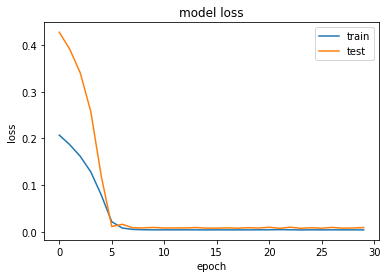

In [67]:
history = lstm_deep.fit(x=train_X, y=train_y, epochs=30, validation_data=(test_X, test_y), batch_size=8, verbose=0)
show_loss(history)

In [68]:
print('LSTM')
eval_model(lstm_deep, test_X, test_y)

LSTM
rmse: 0.008914812767434088
mae: 0.0707050169330773
mape: 0.11197079709905129


(0.008914812767434088, 0.0707050169330773, 0.11197079709905129)

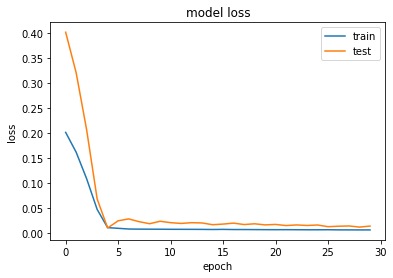

In [69]:
history = gru_deep.fit(x=train_X3, y=train_y3, epochs=30, validation_data=(test_X3, test_y3), batch_size=8, verbose=0)
show_loss(history)

In [70]:
print('GRU')
eval_model(gru_deep, test_X3, test_y3)

GRU
rmse: 0.013289551417082247
mae: 0.09733953760818251
mape: 0.1423558301916494


(0.013289551417082247, 0.09733953760818251, 0.1423558301916494)

### Додати дропаути мiж рекурентними шарами цих моделей, а саме, спробувати застосувати дропаут до входiв кожного шару, виходiв та станiв кожного шару.

In [78]:
# dropouts_inner, droputs_outputs, dropouts_inputs
lstm_deep2 = deep_model([64, 32, 16], tf.keras.layers.LSTM, [0.2]*3, [0.2]*3, [0.1]*3)
gru_deep2 = deep_model([64, 32, 16], tf.keras.layers.GRU, [0.2]*3, [0.2]*3, [0.1]*3)

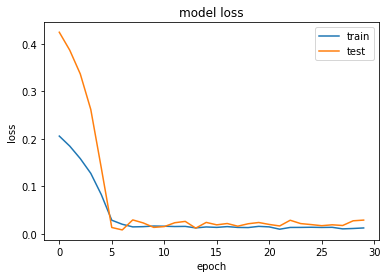

In [79]:
history = lstm_deep2.fit(x=train_X, y=train_y, epochs=30, validation_data=(test_X, test_y), batch_size=8, verbose=0)
show_loss(history)

In [80]:
print('LSTM')
eval_model(lstm_deep2, test_X, test_y)

LSTM
rmse: 0.028717400209508036
mae: 0.15371817831992035
mape: 0.21954636104738046


(0.028717400209508036, 0.15371817831992035, 0.21954636104738046)

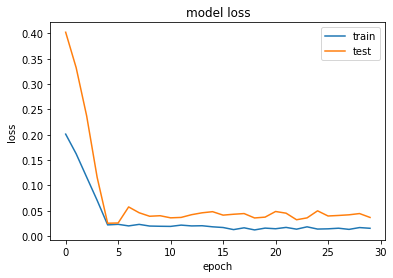

In [81]:
history = gru_deep2.fit(x=train_X3, y=train_y3, epochs=30, validation_data=(test_X3, test_y3), batch_size=8, verbose=0)
show_loss(history)

In [82]:
print('GRU')
eval_model(gru_deep2, test_X3, test_y3)

GRU
rmse: 0.0369424994675926
mae: 0.17599497025421926
mape: 0.25233988134613516


(0.0369424994675926, 0.17599497025421926, 0.25233988134613516)

### Зробити висновки щодо якостi прогнозу на основi глибоких моделей RNN i моделей RNN з дропаутами.
Використання навіть невеликого dropuot погіршує якість навчання моделей, так як і без dropout перенавчання майже не було

### Побудувати i навчити глибоку модель зi згортковими шарами conv1D та шарами max_pool1D. Згортковi шари, як вiдомо, є гарним способом дослiдження локальної структури даних.

In [130]:
def conv_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=64,
               kernel_size=2,
               strides=2,
               activation='relu',
               padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(tf.keras.layers.GRU(20, activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics='mae')
    return model

In [131]:
conv_gru_model = conv_gru()

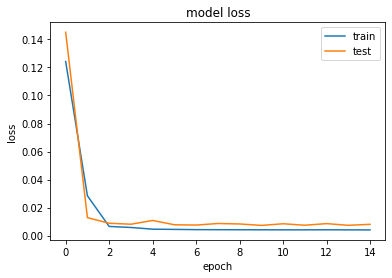

In [132]:
history = conv_gru_model.fit(x=train_X, y=train_y, epochs=15, validation_data=(test_X, test_y), batch_size=8, verbose=0)
show_loss(history)

In [133]:
print('CONV GRU')
eval_model(conv_gru_model, test_X, test_y)

CONV GRU
rmse: 0.008003127800810477
mae: 0.07053997404684349
mape: 0.10448586720392035


(0.008003127800810477, 0.07053997404684349, 0.10448586720392035)

### Побудувати часткову автокореляцiйну функцiю ряду, який прогнозується, i перевiрити гiпотезу щодо присутностi автокореляцiї у цьому рядi.

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


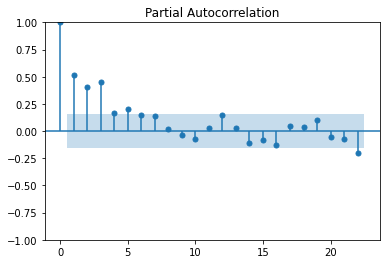

In [90]:
plot_pacf(data['price'].resample('M').mean().dropna().values)
plt.show()

У ряді дійсно присутня часткова автокореляція

### Порiвняти всi моделi i обрати найкращу з них.
Найкращий результат дає одношарова Simple_RNN  (+ шар Dense) з MAE=0.057327. Всі інші моделі без dropout мають MAE <= 0.07, тобто не є сильно гіршими. Також моделі не перенавчаються початково, тож додавання dropout погіршує значення метрик